# 卡尔曼滤波行人状态估计

案例场景，传感器能够直接观测到某行人的速度Vx,Vy，用卡尔曼滤波估算该行人的状态(包含速度和位置）

相关变量约定如下：

行人状态 $x = (p_x,p_y,v_x, v_y)^T$ 

P: 行人不确定性，协方差矩阵

F: 状态转移矩阵

Q: 过程噪声协方差矩阵

K: 卡尔曼滤波增益

H: 观测矩阵

R: 观测噪声协方差矩阵

# step0:随机产生一批测量数据，包含二维速度测量值，图示如下

In [4]:
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt
from scipy.stats import norm

m = 200 #measurements
vx = 20
vy = 10

mx = np.array(vx + np.random.randn(m))
my = np.array(vy + np.random.randn(m))
measurements = np.vstack((mx,my))
print(measurements.shape)
print('Standard Deviation of Acceleration Measurements=%0.2f'%np.std(mx))
#print('You assumed %0.2f in R.'%R[0,0])

(2, 200)
Standard Deviation of Acceleration Measurements=0.98


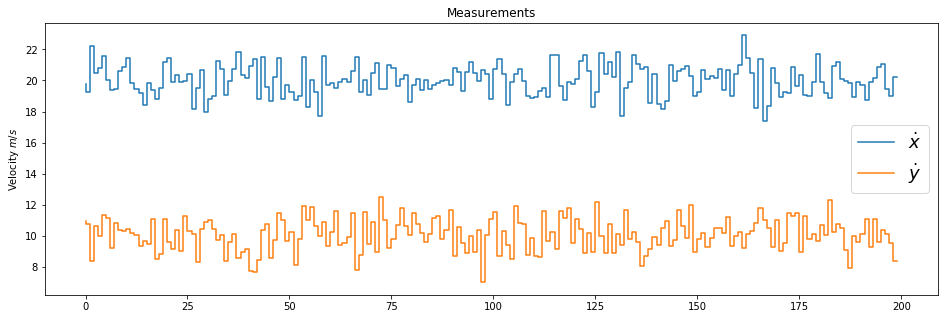

In [5]:
fig = plt.figure(figsize=(16,5))
plt.step(range(m), mx, label='$\dot x $')
plt.step(range(m), my, label='$\dot y $')
plt.ylabel(r'Velocity $m/s$')
plt.title('Measurements')
plt.legend(loc='best',prop={'size':18})
plt.savefig('measurements.png')

# step1:初始化行人状态

包括x,y方向的位置和速度，及行人的不确定性，测量间隔时间dt

x: 行人状态初始值,因未知，所以全设置为0

P: 行人不确定性初始值，不确定性很高

In [6]:
x = np.matrix([[0.0,0.0,0.0,0.0]]).T
print(x,x.shape)
P=np.diag([1000.0,1000.0,1000.0,1000.0])
print(P,P.shape)

[[0.]
 [0.]
 [0.]
 [0.]] (4, 1)
[[1000.    0.    0.    0.]
 [   0. 1000.    0.    0.]
 [   0.    0. 1000.    0.]
 [   0.    0.    0. 1000.]] (4, 4)


# step2:设计过程模型和过程噪声协方差矩阵

设计卡尔曼滤波器时，必须定义两个线性函数，如下图：

ekl006.png

状态转移函数F：该函数从时间k-1到时间k的状态变换进行建模;

测量函数H： 该函数对测量值的计算方式，以及测量值和预测值状态x的关联进行建模;

这些函数的第一部分F，H是模型中的确定性部分，尾项噪声v和噪声w表述的时随机部分，影响预测和测量更新步骤的随机误差；

(1)假设运动为恒速模型，即假设行人速度不变，过程模型可以描述如下

ekl016.png

(2)实际上行人运动过程不一定为恒速，总会有内因(行人自己加速度，无人车内部的加速度控制)和外因(风速，路面光滑程度)等影响；

内因用u表示，是行人或无人车内部控制向量，B是输入控制矩阵；

Bu表示行人由于自身内部动力，引起状态变化；

v表示由于风速，路滑等外因引起的状态变化量，是个随机变量，称为过程噪声；

由于观测物体(行人)自身加速度无法准确和预估，应用中常设置Bu=0,就用随机变量v作为随机噪声；对应卡尔曼公式如下：

008.png

$$
x_k+1 = \left[\begin{matrix}
   1.0&0.&dt&0.\\
   1.0&0.&0.&dt\\
   0&0&1&0 \\
   0&0&0&1 \\
  \end{matrix} 
  \right]*\left[\begin{matrix}
   p_x\\
   p_y\\
   v_x \\
   v_y \\
  \end{matrix} 
  \right] 
$$







v为噪声（实际不可能为恒速，加速度用噪声来表征），物理过程模型为：
$$
x_k+1 = \left[\begin{matrix}
   1.0&0.&dt&0.\\
   1.0&0.&0.&dt\\
   0&0&1&0 \\
   0&0&0&1 \\
  \end{matrix} 
  \right]*\left[\begin{matrix}
   p_x\\
   p_y\\
   v_x \\
   v_y \\
  \end{matrix} 
  \right] + \left[\begin{matrix}
   \frac{1}{2}a_xdt^2\\
   \frac{1}{2}a_ydt^2\\
   a_xdt \\
   a_ydt \\
  \end{matrix} 
  \right]
$$
噪声Q本质上是一个高斯分布v~N(0,Q), 卡尔曼公式2就变成：

$$
p_k^{'} = ap_ka^T + Q
$$


转移矩阵表示为：
$$
 F=
 \left[\begin{matrix}
   1.0&0.&dt&0.\\
   1.0&0.&0.&dt\\
   0&0&1&0 \\
   0&0&0&1 \\
  \end{matrix} 
  \right]
$$


In [7]:
dt = 0.1 # Time step between Filters steps
F = np.matrix([[1.0,0.0,dt,0.0],
               [0.0,1.0,0.0,dt],
               [0.0,0.0,1.0,0.0],
               [0.0,0.0,0.0,1.0]])
print(F,F.shape)

[[1.  0.  0.1 0. ]
 [0.  1.  0.  0.1]
 [0.  0.  1.  0. ]
 [0.  0.  0.  1. ]] (4, 4)


使用传感器可以直接测量行人的速度Vx, Vy，所以测量观测矩阵可以表示为：

$$
 H=
 \left[\begin{matrix}
   0&0&1&0\\
   0&0&0&1 \\
  \end{matrix} 
  \right]
$$

测量噪声的协方差矩阵为：

$$
 R=
 \left[\begin{matrix}
   \sigma_{v_x}^2&0\\
   0&\sigma_{v_y}^2 \\
  \end{matrix} 
  \right]
$$

$\sigma_{v_x}^2, \sigma_{v_y}^2$描述了传感器的测量有“多差”，是传感器固有性质，一般有厂商提供

过程噪声协方差矩阵Q

In [8]:
H = np.matrix([[0.0,0.0,1.0,0.0],
               [0.0,0.0,0.0,1.0]])
print(H, H.shape)
ra = 0.09
R = np.matrix([[ra,0.0],
              [0.0,ra]])
print(R,R.shape)

[[0. 0. 1. 0.]
 [0. 0. 0. 1.]] (2, 4)
[[0.09 0.  ]
 [0.   0.09]] (2, 2)


In [103]:
'''
sv = 0.5
G = np.matrix([[0.5*dt**2],
              [0.5*dt**2],
              [dt],
              [dt]])
Q = G*G.T*sv*2
from sympy import Symbol, Matrix
from sympy.interactive import printing
printing.init_printing()
dts = Symbol('dt')
Qs = Matrix([[0.5*dts**2],[0.5*dts**2],[dts],[dts]])
Qs*Qs.T
'''

"\nsv = 0.5\nG = np.matrix([[0.5*dt**2],\n              [0.5*dt**2],\n              [dt],\n              [dt]])\nQ = G*G.T*sv*2\nfrom sympy import Symbol, Matrix\nfrom sympy.interactive import printing\nprinting.init_printing()\ndts = Symbol('dt')\nQs = Matrix([[0.5*dts**2],[0.5*dts**2],[dts],[dts]])\nQs*Qs.T\n"

In [10]:
noise_ax=0.5
noise_ay=0.5
dt_2 = dt*dt;
dt_3 = dt_2 *dt;
dt_4 = dt_3*dt;

Q_ = np.matrix([[0.25*dt_4*noise_ax,0,0.5*dt_3*noise_ax,0],
               [0, 0.25*dt_4*noise_ay,0, 0.25*dt_3*noise_ay],
               [dt_3/2*noise_ax, 0, dt_2*noise_ax, 0],
               [0, dt_3/2*noise_ay, 0, dt_2*noise_ay]])


In [11]:
I = np.eye(4)
print(I, I.shape)

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]] (4, 4)


随机产生一些测量数据

In [12]:
xt = []
yt = []
dxt = []
dyt = []

Zx = []
Zy = []

Px = []
Py = []
Pdx = []
Pdy = []

Rdx = []
Rdy = []

Kx = []
Ky = []
Kdx =[]
Kdy = []

def save_states(x,Z,P,R,K):
    xt.append(float(x[0]))
    yt.append(float(x[1]))
    dxt.append(float(x[2]))
    dyt.append(float(x[3]))
    
    Zx.append(float(Z[0]))
    Zy.append(float(Z[1]))
    
    Px.append(float(P[0,0]))
    Py.append(float(P[1,1]))
    Pdx.append(float(P[2,2]))
    Pdy.append(float(P[3,3]))
    
    Rdx.append(float(R[0,0]))
    Rdy.append(float(R[1,1]))
    
    Kx.append(float(K[0,0]))
    Ky.append(float(K[1,0]))
    Kdx.append(float(K[2,0]))
    Kdy.append(float(K[3,0]))
    
    

In [13]:
for n in range(len(measurements[0])):
    #Time Update(Prediction)
    x = F*x             #Project the state ahead
    P = F * P *F.T + Q_  #Project the error covariance ahead
    print(Q_)
    #==============================
    
    S = H*P*H.T + R
    K = (P*H.T)*np.linalg.pinv(S)
    
    #Update the estimate via z
    Z = measurements[:,n].reshape(2,1)
    y = Z - (H*x)
    x = x + (K*y)
    
    #update the error convariance
    P = (I - (K*H))*P
    
    #save states (for Plotting)
    save_states(x,Z,P,R,K)
    

[[1.25e-05 0.00e+00 2.50e-04 0.00e+00]
 [0.00e+00 1.25e-05 0.00e+00 1.25e-04]
 [2.50e-04 0.00e+00 5.00e-03 0.00e+00]
 [0.00e+00 2.50e-04 0.00e+00 5.00e-03]]
[[1.25e-05 0.00e+00 2.50e-04 0.00e+00]
 [0.00e+00 1.25e-05 0.00e+00 1.25e-04]
 [2.50e-04 0.00e+00 5.00e-03 0.00e+00]
 [0.00e+00 2.50e-04 0.00e+00 5.00e-03]]
[[1.25e-05 0.00e+00 2.50e-04 0.00e+00]
 [0.00e+00 1.25e-05 0.00e+00 1.25e-04]
 [2.50e-04 0.00e+00 5.00e-03 0.00e+00]
 [0.00e+00 2.50e-04 0.00e+00 5.00e-03]]
[[1.25e-05 0.00e+00 2.50e-04 0.00e+00]
 [0.00e+00 1.25e-05 0.00e+00 1.25e-04]
 [2.50e-04 0.00e+00 5.00e-03 0.00e+00]
 [0.00e+00 2.50e-04 0.00e+00 5.00e-03]]
[[1.25e-05 0.00e+00 2.50e-04 0.00e+00]
 [0.00e+00 1.25e-05 0.00e+00 1.25e-04]
 [2.50e-04 0.00e+00 5.00e-03 0.00e+00]
 [0.00e+00 2.50e-04 0.00e+00 5.00e-03]]
[[1.25e-05 0.00e+00 2.50e-04 0.00e+00]
 [0.00e+00 1.25e-05 0.00e+00 1.25e-04]
 [2.50e-04 0.00e+00 5.00e-03 0.00e+00]
 [0.00e+00 2.50e-04 0.00e+00 5.00e-03]]
[[1.25e-05 0.00e+00 2.50e-04 0.00e+00]
 [0.00e+00 1.25e-05

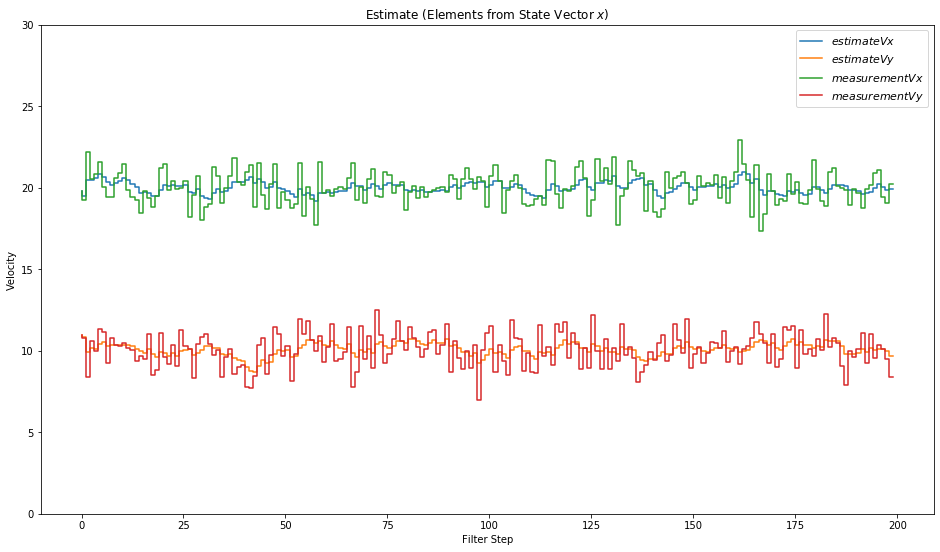

In [16]:
def plot_x():
    fig = plt.figure(figsize=(16,9))
    plt.step(range(len(measurements[0])), dxt, label='$estimateVx $')
    plt.step(range(len(measurements[0])), dyt, label='$estimateVy $')
    
    plt.step(range(len(measurements[0])),measurements[0],label='$measurementVx$')
    plt.step(range(len(measurements[0])),measurements[1],label='$measurementVy$')
    
    #plt.axhline(vx, colors='#999999',label = '$trueVx$')
    #plt.axhline(vy, colors='#999999',label = '$trueVy$')
    
    plt.xlabel('Filter Step')
    plt.title('Estimate (Elements from State Vector $x$)')
    plt.legend(loc='best',prop={'size':11})
    plt.ylim([0,30])
    plt.ylabel('Velocity')
    plt.savefig('velocity.png')
plot_x()
                


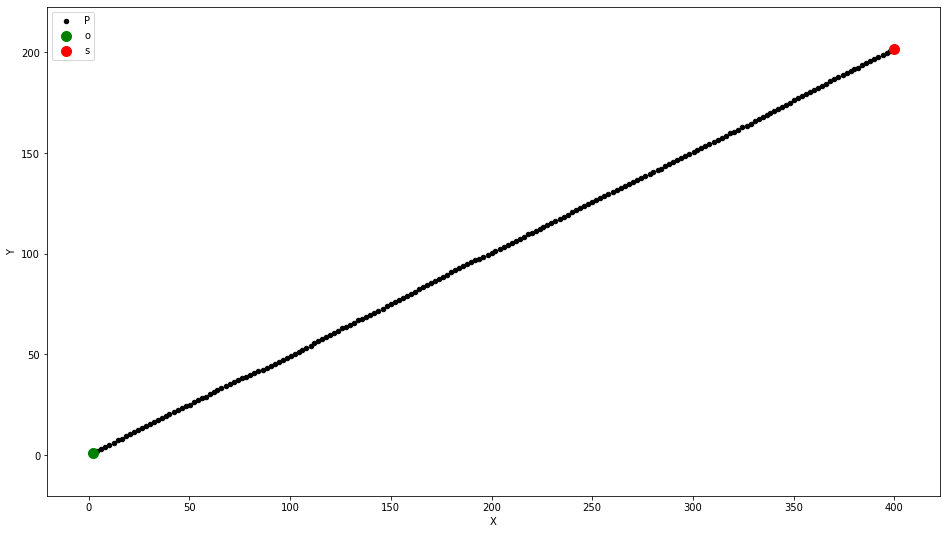

In [17]:
def plot_xy():
    fig = plt.figure(figsize=(16,9))
    plt.scatter(xt,yt,s=20,label='State', c = 'k')
    plt.scatter(xt[0],yt[0],s = 100, label='Start', c = 'g')
    plt.scatter(xt[-1], yt[-1],s=100,label='Goal', c = 'r')
    
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend('Position')
    plt.axis('equal')
    plt.savefig('position.png')
    
plot_xy()